<a href="https://colab.research.google.com/github/amitkag85/CKAD-exercises/blob/master/4__Recurrent_Neural_Networks_(RNNs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Layer Overview

So far we have seen `Linear` layers, which have a fixed input dimension, and convolution layers, which slide a fixed size window over their input. Both of these work on fixed-length inputs. While they can process larger inputs in the form of batches, each example is processed in parallel and no information can be shared between them. For some use cases, such as fixed size images or a known set of coumns in a record, this is perfectly fine. However when working with time series data (which includes text) we often do not know the input length ahead of time, or it is generally variable. While we can decide on some maximum sequence length and pad shorter inputs, it would be nice if we could take sequences of arbitrary length as an input directly. This is exactly what **Recurrent Neural Networks** (RNNs) are for.

RNNs work based on two inputs: the current sequence value and a *hidden state*. Hidden state is just a fancy name for memory, which is a vector that we use to store information from previous inputs. The basic pseudo code using an RNN is:

```python
h = torch.zeros(...)
for x in inputs:
  h = rnn(x, h)
# do something with h
```

The main advantage of RNNs is that they can (theoretically at lease) handle arbitrarily long sequences. In reality there is a practical limit to how much they can remember based on (at least) two major factors:

* vanishing/exploding gradients making it difficult to train on longer sequences (addressed by [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) and [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU/))
* the fact that the hidden state is a fixed size, only offering finite memory capacity

One other thing to keep in mind is that since RNNs process inputs sequentially they are inherently sequential and thus do not benefit nearly as much from GPUs (although they can still be trained on batches, provided all inputs are padded to be the same length).

A classic (yet dated) blog post by Andrej Karpathy is [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Even though things have changed quite a lot since it was written, it is still a good overview of some of the uses for RNNs.

In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from tqdm import trange
import matplotlib.pyplot as plt

# RNN Cell



In [ ]:
in_dim = 2
hidden_dim = 5

rnn = nn.RNNCell(in_dim, hidden_dim)
print(rnn)

RNNCell(2, 5)


In [ ]:
print(rnn.weight_ih.size())
print(rnn.weight_hh.size())

torch.Size([5, 2])
torch.Size([5, 5])


# Running

In [ ]:
batch_size = 3
steps = 10

x = torch.randn(steps, batch_size, in_dim)
print(x.size())
h = torch.zeros(batch_size, hidden_dim)
print(h.size())
print(h)

torch.Size([10, 3, 2])
torch.Size([3, 5])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [ ]:
for i, v in enumerate(x):
  print(i, v.size())
  h = rnn(v, h)

print(h.size())
print(h)

0 torch.Size([3, 2])
1 torch.Size([3, 2])
2 torch.Size([3, 2])
3 torch.Size([3, 2])
4 torch.Size([3, 2])
5 torch.Size([3, 2])
6 torch.Size([3, 2])
7 torch.Size([3, 2])
8 torch.Size([3, 2])
9 torch.Size([3, 2])
torch.Size([3, 5])
tensor([[-0.3921, -0.4068, -0.7080, -0.7752, -0.2622],
        [ 0.1492, -0.0723, -0.1604, -0.6498,  0.3540],
        [ 0.2537, -0.0919, -0.1733, -0.6678,  0.2148]],
       grad_fn=<TanhBackward0>)


# What's happening

From a blog post by Andrej Karpathy is [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

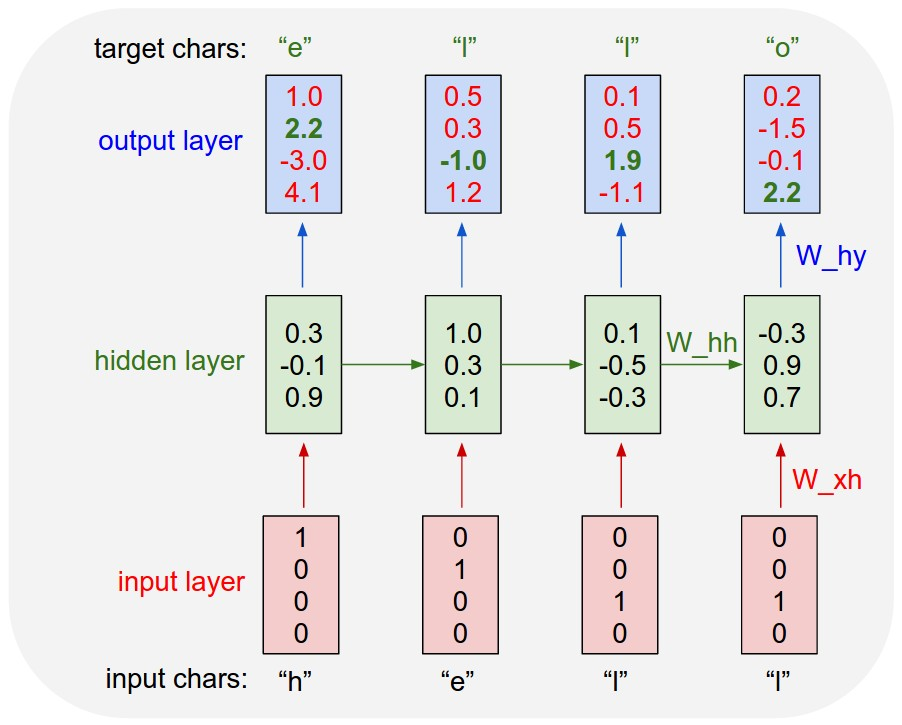

# Example

## Making the Data

For this toy example we need to create vectors for each letter in the word "hello." To do this, we will use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot). Since we have 4 unique letters, we will need a vector of size 4 for each letter.

In [ ]:
c_h = torch.tensor([1, 0, 0, 0])
c_e = torch.tensor([0, 1, 0, 0])
c_l = torch.tensor([0, 0, 1, 0])
c_o = torch.tensor([0, 0, 0, 1])

Now we can stack these together to make our total vocabulary.

In [ ]:
vocab = torch.stack([c_h, c_e, c_l, c_o])
print(vocab.size())
print(vocab)

In [ ]:
hello = torch.stack([c_h, c_e, c_l, c_l, c_o]).float()
print(hello.size())
print(hello)

## Feed-forward Model

In [ ]:
class HelloModel(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim):
    super().__init__()
    self.hidden_dim = hidden_dim

    self.layers = nn.Sequential(
        nn.Linear(in_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(hidden_dim, out_dim)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
text = 'hello'
list(zip(text, text[1:]))

In [ ]:
data = list(zip(hello, hello[1:]))

In [ ]:
data

In [ ]:
in_dim = 4
hidden_dim = 20

model = HelloModel(in_dim, hidden_dim, in_dim)
print(model)

# Training

Create an optimizer for our model. This is what updates the model's parameters and allows it to learn.

In [ ]:
opt = AdamW(model.parameters())

In [ ]:
epochs = 100

loss_fn = nn.CrossEntropyLoss()
losses = []

for epoch in trange(epochs):
  for x, y in data:
    opt.zero_grad()
    y_hat = model(x)
    loss = loss_fn(y_hat, y.argmax())
    loss.backward()
    opt.step()
    losses.append(loss.detach().tolist())

In [ ]:
plt.plot(torch.tensor(losses))

In [ ]:
model.eval()

for x, y in zip(hello, hello[1:]):
  y_hat = model(x)
  print(y_hat.softmax(dim=-1), f' prediction: {y_hat.argmax().tolist()}', f' target: {y.argmax().tolist()}')

## Recurrent Model

An RNN requires at least:

* an RNN layer (here we will use [RNNCell](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html#torch.nn.RNNCell)) that takes in each input and the previous hidden state and produces an updated hidden state
* a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layer for converting the hidden state into the output

For more complicated tasks we could need a feature extractor of some sort before the RNN layer, a more complex way to process the output, even multiple RNN layers in some cases.

In [ ]:
class HelloModel(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim):
    super().__init__()
    self.hidden_dim = hidden_dim

    self.rnn = nn.RNNCell(in_dim, hidden_dim)

    self.output = nn.Linear(hidden_dim, out_dim)

  def forward(self, x, h):
    h = self.rnn(x, h)
    y = self.output(h)
    return y, h

Create an instance of our model.

In [ ]:
in_dim = 4
hidden_dim = 20

model = HelloModel(in_dim, hidden_dim, in_dim)
print(model)

Each traning example needs to be the letters up to some position, and the letter at the position in question.

In [ ]:
# example
text = 'hello'

for i in range(1, len(text)):
  print(text[:i], text[i])

In terms of conditional probabilities:

p('e' | 'h')

p('l' | 'he')

p('l' | 'hel')

p('o' | 'hell')

In [ ]:
data = []

for i in range(1, hello.size(0)):
  x = hello[:i]
  y = hello[i]
  print(i, x, y)
  data.append((x, y))

In [ ]:
data

## Training

In [ ]:
opt = AdamW(model.parameters())

In [ ]:
epochs = 200

loss_fn = nn.CrossEntropyLoss()
losses = []

for epoch in trange(epochs):
  h = torch.zeros(hidden_dim)

  opt.zero_grad()
  loss = 0
  for x, y in data:
    for c in x:
      y_hat, h = model(c, h)
    loss = loss + loss_fn(y_hat, y.argmax())

  loss.backward()
  opt.step()
  losses.append(loss.detach().tolist())

In [ ]:
plt.plot(torch.tensor(losses))

In [ ]:
model.eval()

h = torch.zeros(hidden_dim)
for x, y in zip(hello, hello[1:]):

  y_hat, h = model(x, h)
  print(y_hat.softmax(dim=-1), f' prediction: {y_hat.argmax().tolist()}', f' target: {y.argmax().tolist()}')